In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-activity-recognition-with-smartphones/train.csv
/kaggle/input/human-activity-recognition-with-smartphones/test.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
np.random.seed(3)

In [3]:
df = pd.read_csv(r'/kaggle/input/human-activity-recognition-with-smartphones/train.csv')
df = df.sample(len(df)).reset_index(drop=True)
df.drop('subject',axis=1,inplace = True)

In [4]:
df.Activity.value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [5]:
df.Activity = df.Activity.astype('category').cat.codes

In [6]:
X=df.drop('Activity',axis=1)
y = df['Activity']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [7]:
def build_model(n_hidden=1,n_neurons=50,optimizer='RMSprop'):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=X_train.shape[1:]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation='relu'))
        model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(6,activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model

In [8]:
keras_model = keras.wrappers.scikit_learn.KerasClassifier(build_model)
history = keras_model.fit(X_train,y_train,epochs=150,validation_data=(X_valid, y_valid),
                callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/150
173/173 [==============================] - 0s 2ms/step - loss: 0.4080 - accuracy: 0.8466 - val_loss: 0.1434 - val_accuracy: 0.9548
Epoch 2/150
173/173 [==============================] - 0s 2ms/step - loss: 0.1474 - accuracy: 0.9445 - val_loss: 0.0920 - val_accuracy: 0.9608
Epoch 3/150
173/173 [==============================] - 0s 1ms/step - loss: 0.1133 - accuracy: 0.9559 - val_loss: 0.0677 - val_accuracy: 0.9733
Epoch 4/150
173/173 [==============================] - 0s 1ms/step - loss: 0.0849 - accuracy: 0.9661 - val_loss: 0.0627 - val_accuracy: 0.9750
Epoch 5/150
173/173 [==============================] - 0s 1ms/step - loss: 0.0730 - accuracy: 0.9723 - val_loss: 0.0580 - val_accuracy: 0.9788
Epoch 6/150
173/173 [==============================] - 0s 1ms/step - loss: 0.0653 - accuracy: 0.9748 - val_loss: 0.0621 - val_accuracy: 0.9766
Epoch 7/150
173/173 [==============================] - 0s 1ms/step - loss: 0.0534 - accuracy: 0.9793 - val_loss: 0.0537 - val_accuracy: 0.9771

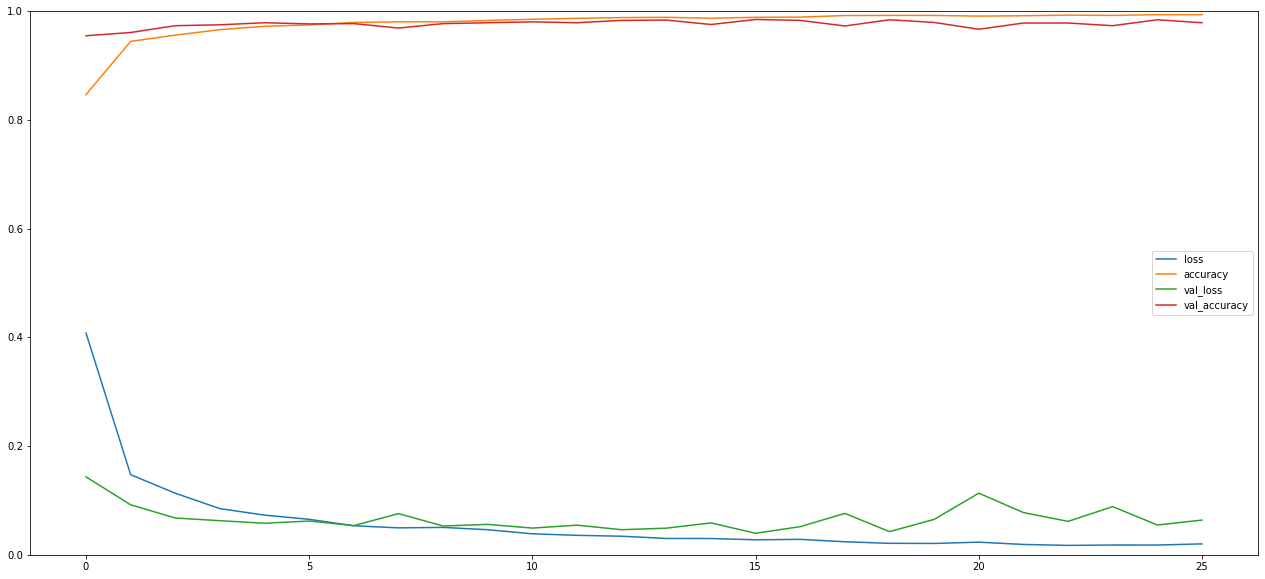

In [9]:
pd.DataFrame(history.history).plot(figsize=(22, 10))
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [10]:
param_distribs = {'n_hidden':(1,2,3,4),
                  'n_neurons':(50,100,150,200,250),
                  'optimizer': ['RMSprop','Adam','SGD']
                  }
rnd = RandomizedSearchCV(keras_model,param_distribs, n_iter=10, cv=3)
rnd.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid),
       callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
115/115 [==============================] - 0s 4ms/step - loss: 0.5816 - accuracy: 0.7560 - val_loss: 0.3482 - val_accuracy: 0.8553
Epoch 2/100
115/115 [==============================] - 0s 3ms/step - loss: 0.2380 - accuracy: 0.9108 - val_loss: 0.0997 - val_accuracy: 0.9597
Epoch 3/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1720 - accuracy: 0.9361 - val_loss: 0.5906 - val_accuracy: 0.8624
Epoch 4/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1600 - accuracy: 0.9478 - val_loss: 0.1667 - val_accuracy: 0.9374
Epoch 5/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1265 - accuracy: 0.9540 - val_loss: 0.1241 - val_accuracy: 0.9657
Epoch 6/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1124 - accuracy: 0.9595 - val_loss: 0.0968 - val_accuracy: 0.9668
Epoch 7/100
115/115 [==============================] - 0s 3ms/step - loss: 0.0995 - accuracy: 0.9665 - val_loss: 0.0694 - val_accuracy: 0.9739

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb135c231d0>,
                   param_distributions={'n_hidden': (1, 2, 3, 4),
                                        'n_neurons': (50, 100, 150, 200, 250),
                                        'optimizer': ['RMSprop', 'Adam',
                                                      'SGD']})

In [11]:
print(rnd.best_params_)
print(rnd.best_score_)

{'optimizer': 'Adam', 'n_neurons': 150, 'n_hidden': 1}
0.9805948535601298


In [12]:
model = rnd.best_estimator_.model
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 561)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 150)               84300     
_________________________________________________________________
dropout_85 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 6)                 906       
Total params: 85,206
Trainable params: 85,206
Non-trainable params: 0
_________________________________________________________________


In [13]:
test = pd.read_csv(r'/kaggle/input/human-activity-recognition-with-smartphones/test.csv')
test.drop('subject',axis=1,inplace = True)
test.Activity = test.Activity.astype('category').cat.codes
test_X = test.drop('Activity',axis=1)
test_X = scaler.transform(test_X)
test_y = test['Activity']
model.evaluate(test_X,test_y)

93/93 [==============================] - 0s 962us/step - loss: 0.3758 - accuracy: 0.9376


[0.3758392632007599, 0.9375635981559753]

In [14]:
y_pred=model.predict_classes(test_X)
print(classification_report(test_y,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       537
           1       0.94      0.91      0.92       491
           2       0.91      0.94      0.92       532
           3       0.97      0.90      0.93       496
           4       0.86      0.95      0.90       420
           5       0.96      0.93      0.94       471

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947

